### Hate & cyberbullying analysis - model preparation
źródła: http://2019.poleval.pl/index.php/tasks/task6 & materiały wykładowe (Text Mining @ PW, 2021)

Co zrobiłem:
- przygotowałem 2 alternatywne modele ale i tak są one marne (nie użyto w dalszych analizach)

Etykiety:
* 0 - neutralna wypowiedź
* 1 - cyberbullying -> skierowany do osoby prywatnej
* 2 - hate-speech -> skierowany do osoby publicznje/insytutcji/dużej grupy

In [2]:
# ! pip install sklearn

In [3]:
import pandas as pd
import spacy
# For displaying spacy features
from spacy import displacy
from tqdm import tqdm
import numpy as np
from spacy.lang.pl.stop_words import STOP_WORDS
from spacy.lang.pl.examples import sentences

import shutil
import requests

In [4]:
x_train_df = pd.read_csv('./hate_speech/training_set_clean_only_text.txt', sep="\n", header=None, names=['text'], encoding ='utf-8')
y_train = pd.read_csv('./hate_speech/training_set_clean_only_tags.txt', header=None, names=['hate_speech'])
x_test_df = pd.read_csv('./hate_speech/test_set_only_text.txt', sep="\n", header=None, names=['text'], encoding ='utf-8')
y_test = pd.read_csv('./hate_speech/test_set_only_tags.txt', header=None, names=['hate_speech'])

In [5]:
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 100)
print(f"Liczba obserwacji w zbiorze treningowym: {x_train_df.count()[0]}")
x_train_df.head(100)

Liczba obserwacji w zbiorze treningowym: 10041


,text
0,"Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi."
1,@anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe
2,"@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów."
3,@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.
4,"Odrzut natychmiastowy, kwaśna mina, mam problem"
5,"Jaki on był fajny xdd pamiętam, że spóźniłam się na jego pierwsze zajęcia i to sporo i za karę kazał mi usiąść w pierwszej ławce XD"
6,@anonymized_account No nie ma u nas szczęścia 😉
7,@anonymized_account Dawno kogoś tak wrednego nie widziałam xd
8,"@anonymized_account @anonymized_account Zaległości były, ale ważne czy były wezwania do zapłaty z których się klub nie wywiązał."
9,@anonymized_account @anonymized_account @anonymized_account Gdzie jest @anonymized_account . Brudziński jesteś kłamcą i marnym kutasem @anonymized_account


In [6]:
print(f"Liczba obserwacji w zbiorze treningowym: {x_test_df.count()[0]}")
x_test_df.head()

Liczba obserwacji w zbiorze treningowym: 1000


,text
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok."
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka."
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁"
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?


In [7]:
### '0 - (non-harmful)', '1 - (cyberbullying)', '2 - (hate-speech)'
### Rozkład zmiennej celu
y_train['hate_speech'].value_counts(normalize=True)

0    0.915247
2    0.059556
1    0.025197
Name: hate_speech, dtype: float64

In [8]:
nlp = spacy.load("pl_core_news_lg")

#### Czyszczenie danych z użyciem Spacy

In [9]:
retweet_token = 'RT'
def clean_with_spacy(spacy_doc):
    tokens_cl = [str(token.lemma_.lower()).replace(retweet_token.lower(), "") for token in spacy_doc
                 if not any([token.is_punct, token.is_stop, token.like_num, token.is_currency, token.like_email, not(token.is_alpha)])]
    return " ".join(tokens_cl).strip()

In [10]:
def spacy_pipeline(dataframe, text_col):
    text_cleaned = []
    for doc in tqdm(nlp.pipe(dataframe[text_col])):
        text_cleaned.append(clean_with_spacy(doc))
    return text_cleaned
x_train_df["cleaned_text"] = spacy_pipeline(x_train_df, "text")

10041it [00:23, 434.05it/s]


In [11]:
x_train_df.head()

,text,cleaned_text
0,"Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.",faworyt tytuł cracovia zobaczyć typ sprawdzić
1,@anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe,brawo daria kibic dobry zły
2,"@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.",supera polski premiera składać kwiat grób kolaborant doczekać czas
3,@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.,inny droga
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",odrzut natychmiastowy kwaśny mina problem


#### Modelowanie

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from utils import plot_confusion_matrix

In [13]:
def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (metrics.accuracy_score(y, yPred),
            metrics.f1_score(y, yPred, average='micro'),
            metrics.f1_score(y, yPred, average='macro'))

def my_scorer(estimator, x, y):
    a, p, r = getScores(estimator, x, y)
    print("Accuracy: {} | F1 micro: {} | F1 macro: {}".format(a, p, r))
    return a+p+r

In [14]:
clf = SGDClassifier(loss='hinge', penalty='l2', learning_rate='optimal', alpha=1e-4, random_state=42)
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', clf),
               ])

In [15]:
x_train = x_train_df["cleaned_text"]
scores = cross_val_score(pipe, x_train, np.ravel(y_train), scoring=my_scorer, cv=10)

Accuracy: 0.909452736318408 | F1 micro: 0.909452736318408 | F1 macro: 0.3539899978256143
Accuracy: 0.9183266932270916 | F1 micro: 0.9183266932270916 | F1 macro: 0.3850994272792075
Accuracy: 0.9193227091633466 | F1 micro: 0.9193227091633466 | F1 macro: 0.38381518928603037
Accuracy: 0.9123505976095617 | F1 micro: 0.9123505976095617 | F1 macro: 0.37125902992776055
Accuracy: 0.9163346613545816 | F1 micro: 0.9163346613545816 | F1 macro: 0.36632008455620285
Accuracy: 0.9123505976095617 | F1 micro: 0.9123505976095617 | F1 macro: 0.3852631578947368
Accuracy: 0.9153386454183267 | F1 micro: 0.9153386454183267 | F1 macro: 0.38241829737054234
Accuracy: 0.9123505976095617 | F1 micro: 0.9123505976095617 | F1 macro: 0.387597825979132
Accuracy: 0.9183266932270916 | F1 micro: 0.9183266932270916 | F1 macro: 0.37527632344386275
Accuracy: 0.9223107569721115 | F1 micro: 0.9223107569721115 | F1 macro: 0.3998572546852696


In [16]:
pipe.fit(x_train, y_train.values.ravel())

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(random_state=42))])

#### Walidacja na zbiorze testowym

In [17]:
x_test = spacy_pipeline(x_test_df, "text")

1000it [00:02, 454.12it/s]


In [18]:
y_pred = pipe.predict(x_test)

In [19]:
print("SGD Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("SGD F1 micro:",metrics.f1_score(y_test, y_pred, average='micro'))
print("SGD F1 macro:",metrics.f1_score(y_test, y_pred, average='macro'))

SGD Accuracy: 0.873
SGD F1 micro: 0.8729999999999999
SGD F1 macro: 0.3557344480648881


In [20]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
y_pred = dummy_clf.predict(x_test)
print("Dummy classifier Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Dummy classifier F1 micro:",metrics.f1_score(y_test, y_pred, average='micro'))
print("Dummy classifier F1 macro:",metrics.f1_score(y_test, y_pred, average='macro'))

Dummy classifier Accuracy: 0.866
Dummy classifier F1 micro: 0.866
Dummy classifier F1 macro: 0.3093962129331904


In [21]:
print(classification_report(y_test, y_pred, target_names=['0 - non harmful', '1 - cyberbulying', '2 - hate speech']))

                  precision    recall  f1-score   support

 0 - non harmful       0.87      1.00      0.93       866
1 - cyberbulying       0.00      0.00      0.00        25
 2 - hate speech       0.00      0.00      0.00       109

        accuracy                           0.87      1000
       macro avg       0.29      0.33      0.31      1000
    weighted avg       0.75      0.87      0.80      1000



C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [22]:
print(metrics.classification_report(y_test, y_pred,digits=3, target_names=['0 - non harmful', '1 - cyberbulying', '2 - hate speech']))

                  precision    recall  f1-score   support

 0 - non harmful      0.866     1.000     0.928       866
1 - cyberbulying      0.000     0.000     0.000        25
 2 - hate speech      0.000     0.000     0.000       109

        accuracy                          0.866      1000
       macro avg      0.289     0.333     0.309      1000
    weighted avg      0.750     0.866     0.804      1000



C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [23]:
confusion_matrix(y_test, y_pred)

array([[866,   0,   0],
       [ 25,   0,   0],
       [109,   0,   0]], dtype=int64)

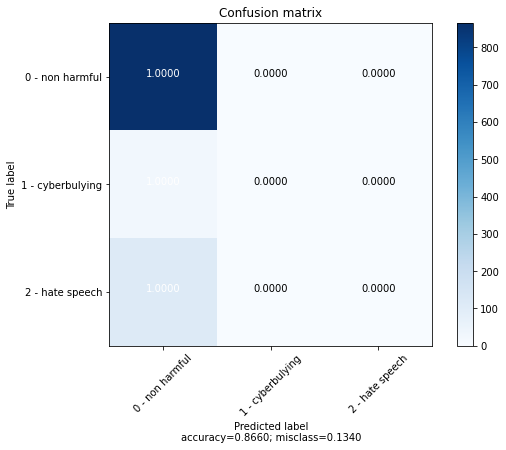

In [24]:
plot_confusion_matrix.plot_confusion_matrix(confusion_matrix(y_test, y_pred), target_names=['0 - non harmful', '1 - cyberbulying', '2 - hate speech'])

#### Model alternatywny: SVM + TfidfVectorizer
porównywalny z modelem z zajęć

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC

In [26]:
text_clf = Pipeline([ ('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(decision_function_shape='ovr')),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))

C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0      0.869     1.000     0.930       866
           1      0.000     0.000     0.000        25
           2      1.000     0.028     0.054       109

    accuracy                          0.869      1000
   macro avg      0.623     0.343     0.328      1000
weighted avg      0.861     0.869     0.811      1000



C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [27]:
confusion_matrix(y_test, y_pred)

array([[866,   0,   0],
       [ 25,   0,   0],
       [106,   0,   3]], dtype=int64)

#### Model alternatywny: Adaptive Boost + TFIDF
source: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
nieco lepszy od modelu z zajęć

In [28]:
from sklearn.ensemble import AdaBoostClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', AdaBoostClassifier()),
 ])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)
score = text_clf.score(x_test, y_test)

print(metrics.classification_report(y_test, y_pred,digits=3))

C:\Users\piotr\anaconda3\envs\tm_experiment\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0      0.876     0.993     0.931       866
           1      0.000     0.000     0.000        25
           2      0.786     0.101     0.179       109

    accuracy                          0.871      1000
   macro avg      0.554     0.365     0.370      1000
weighted avg      0.844     0.871     0.826      1000



In [29]:
confusion_matrix(y_test, y_pred)

array([[860,   3,   3],
       [ 25,   0,   0],
       [ 97,   1,  11]], dtype=int64)

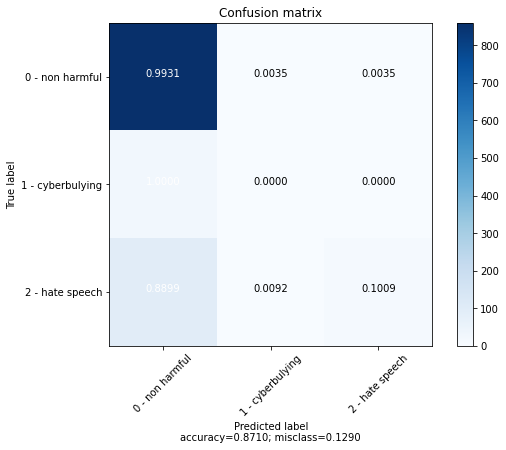

In [30]:
plot_confusion_matrix.plot_confusion_matrix(confusion_matrix(y_test, y_pred), target_names=['0 - non harmful', '1 - cyberbulying', '2 - hate speech'])

Uwagi:
Niestety model jest za słaby by go dalej użyć...